# 爬取個股當日沖銷交易

爬取個股當日沖銷交易後，做成dataframe來產生圖表

將要爬取的股票代號，寫在記事本內，上市才可以，上櫃是不同的資料來源

In [260]:
import requests
import pandas as pd
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import glob  # 類似開檔案的動作
from io import StringIO
import warnings
warnings.filterwarnings("ignore")

def truncate(sio):
    sio.truncate(0) # 清空第0個位置之後的資料
    sio.seek(0)  #保險一點多寫用seek從第0個位置開始添加
    return sio


class stock:
    def __init__(self, save_file_path):
        if not os.path.exists(save_file_path):
            os.makedirs(save_file_path)
        
    # 讀取 stock_list.txt中要爬的股票代號
    def get_run_list(self,list_name):
        stock_list = []
        with open(list_name, 'r') as f:
            txt = f.read()
        stock_list = txt.strip('\n').replace('\n',',').split(',')
        return stock_list
    
    def run_crawl_stock(self, save_file_path, stock_id, start_month, end_month):
        month_range = [str(data).replace('-','').split(' ')[0] for data in pd.date_range(start = start_month, end = end_month, freq = 'MS')]

        columns = ["日期","暫停當沖註記","成交股數","買進成交金額","賣出成交金額"]
        stock_df =pd.DataFrame(columns = columns)



        for m in month_range:
            url = 'https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date='+ m +'&stockNo='+stock_id
            print(' - processing:',url)
            headers = {'User-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}
            res = requests.get(url, headers = headers)
            res.text
            io_csv_info = StringIO(res.text)

            while True:  # 篩選掉第一段所有股票統計
                line = io_csv_info.readline()
                if '暫停現股賣出後現款買進當沖註記' in line:    # 直接取到各股的標題列，後面的資料才是要的
                    break

            while True:
                line = io_csv_info.readline()
                info_list = line.split('","')
                info_list[0] = info_list[0].strip('"')
                info_list[-1] = info_list[-1].strip('",\r\n')
            #     print(info_list)
                if '"備註:"\r\n' in line:
                    break

                df = pd.DataFrame([info_list],columns = columns)
                stock_df = stock_df.append(df,ignore_index = True)

            truncate(io_csv_info) # 清除舊有的記憶體資料
            time.sleep(1)
            
        stock_df.to_csv(save_file_path + f'/csv/{stock_id}.csv')
        print(f'最後日期 {stock_df.values[-1][0]} 已存檔')

        return (stock_df, stock_id)
        
        
    def check_df(self, save_file_path, stock_id):
        #看一下資料內容
        paths = glob.glob(f'./{save_file_path}/csv/{stock_id}.csv') 
        path = paths[0]
        df = pd.read_csv(path)
        df = df.drop(['Unnamed: 0'], axis = 1) # 將最前面的無用index刪除
        
        # 字串轉成數字
        df['成交股數'] = df['成交股數'].apply(lambda x:float(x.replace(',','')) if type(x)==str else x)
        df['買進成交金額'] = df['買進成交金額'].apply(lambda x:float(x.replace(',','')) if type(x)==str else x)
        df['賣出成交金額'] = df['賣出成交金額'].apply(lambda x:float(x.replace(',','')) if type(x)==str else x)
        # 股數轉成張、元換成萬元
        df['成交股數'] = df['成交股數'].apply(lambda x:(x/1000))  # 換成張數
        df['買進成交金額'] = df['買進成交金額'].apply(lambda x:(x/10000))  # 單位換成(萬)
        df['賣出成交金額'] = df['賣出成交金額'].apply(lambda x:(x/10000))  # 單位換成(萬)
        df['當沖損益'] = df['賣出成交金額']-df['買進成交金額']
        df['positive'] = df['當沖損益'] > 0
        return df

    def draw_plt(self, df, stock_id):
        date = df['日期'].tail(30)
        incoming_profit = df['當沖損益'].tail(30)

        #要將當日的圖存在最後一個日期的資料夾中
        l_date = str(df.values[-1][0].replace('/','-'))
        if not os.path.exists(f'{save_file_path}/{l_date}'):
            os.makedirs(f'{save_file_path}/{l_date}')
        #******
    
    
    
        # Figure Size 
        fig, ax = plt.subplots(figsize=(16, 9)) 

        # Horizontal Bar Plot 
        ax.barh(date, incoming_profit, color=df.positive.map({True: 'g', False: 'r'})) 

        # Remove x, y Ticks 
        ax.xaxis.set_ticks_position('none') 
        ax.yaxis.set_ticks_position('none') 

        # Add padding between axes and labels 標籤與框線的間距
        ax.xaxis.set_tick_params(pad=5) 
        ax.yaxis.set_tick_params(pad=10) 

        # Add x, y gridlines 網格
        ax.grid(b=True, color='grey', 
                linestyle='-.', linewidth=0.5, 
                alpha=0.2) 

        # Show top values 反轉y軸現由小到大
        ax.invert_yaxis() 

        # Add annotation to bars 在右側顯示數值
        for i in ax.patches:
            plt.text(i.get_width()+0.2, i.get_y()+0.5, 
                     str(round((i.get_width()), 2)), 
                     fontsize=10, fontweight='bold', 
                     color='black') 

        # add Plot Title 上面顯示圖表名稱
        ax.set_title(f'{stock_id} Day-trading ', 
                     loc='center', ) 

        # Add Text watermark 右上角浮水印
        fig.text(0.88, 0.82, 'Hao made', fontsize=12, 
                 color='grey', ha='right', va='bottom', 
                 alpha=0.7) 
        
        # 儲存圖片
        plt.savefig(f'{save_file_path}/{l_date}/{stock_id}.png')
    
        # Show Plot 
        return plt.show()

 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220201&stockNo=2330
 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220301&stockNo=2330
最後日期 111/03/17 已存檔


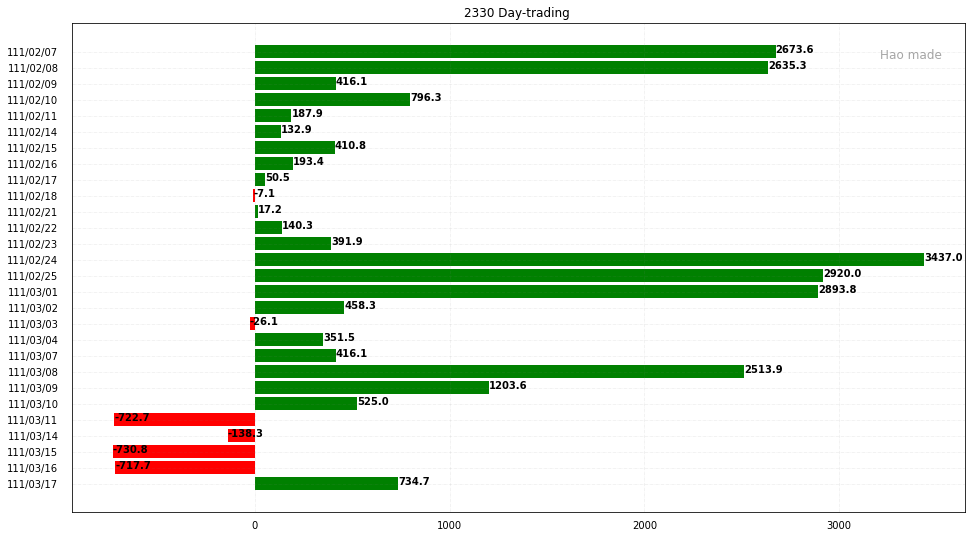

 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220201&stockNo=2303
 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220301&stockNo=2303
最後日期 111/03/17 已存檔


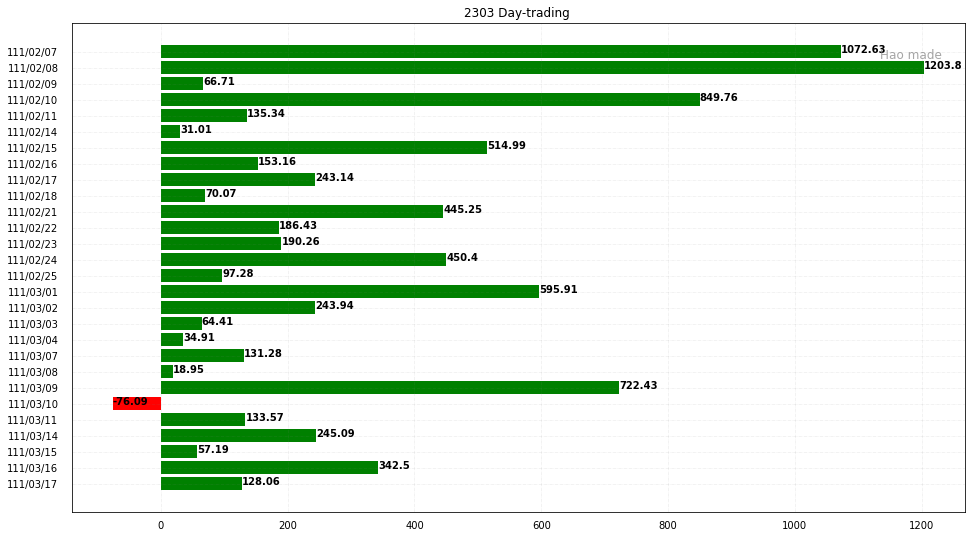

 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220201&stockNo=8046
 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220301&stockNo=8046
最後日期 111/03/17 已存檔


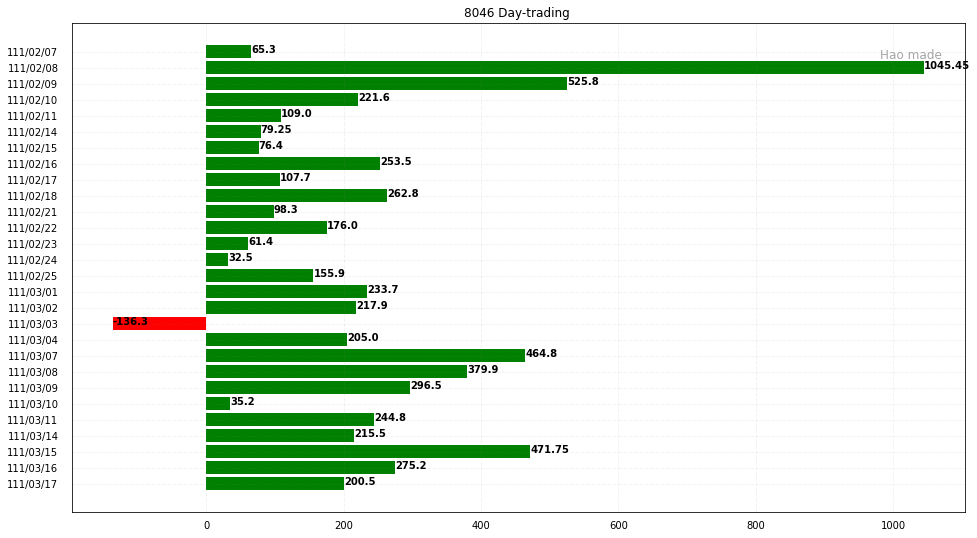

 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220201&stockNo=3037
 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220301&stockNo=3037
最後日期 111/03/17 已存檔


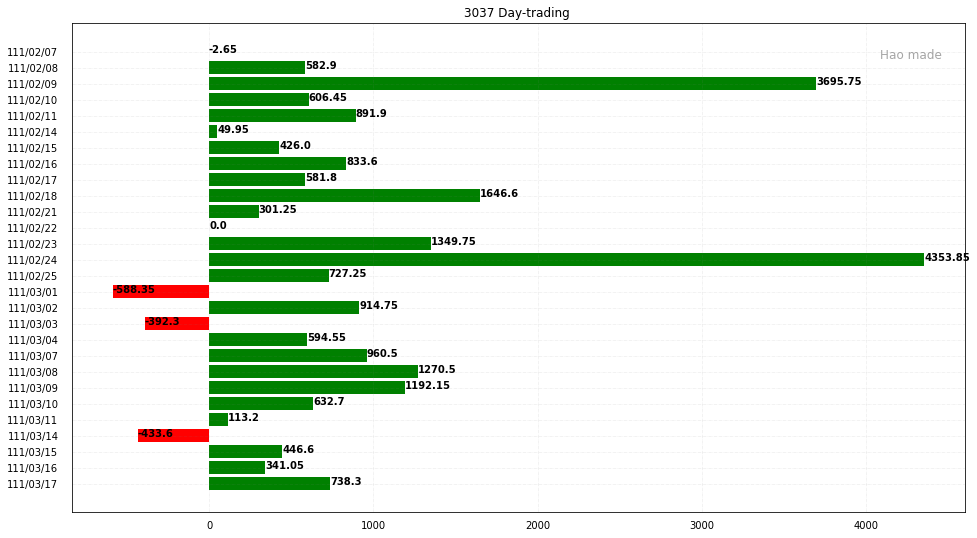

 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220201&stockNo=2603
 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220301&stockNo=2603
最後日期 111/03/17 已存檔


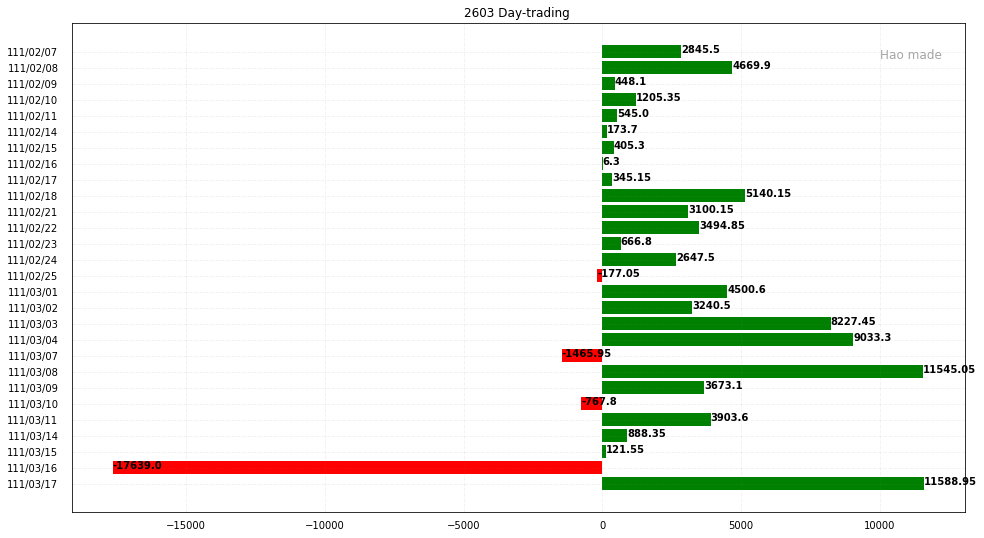

 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220201&stockNo=2609
 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220301&stockNo=2609
最後日期 111/03/17 已存檔


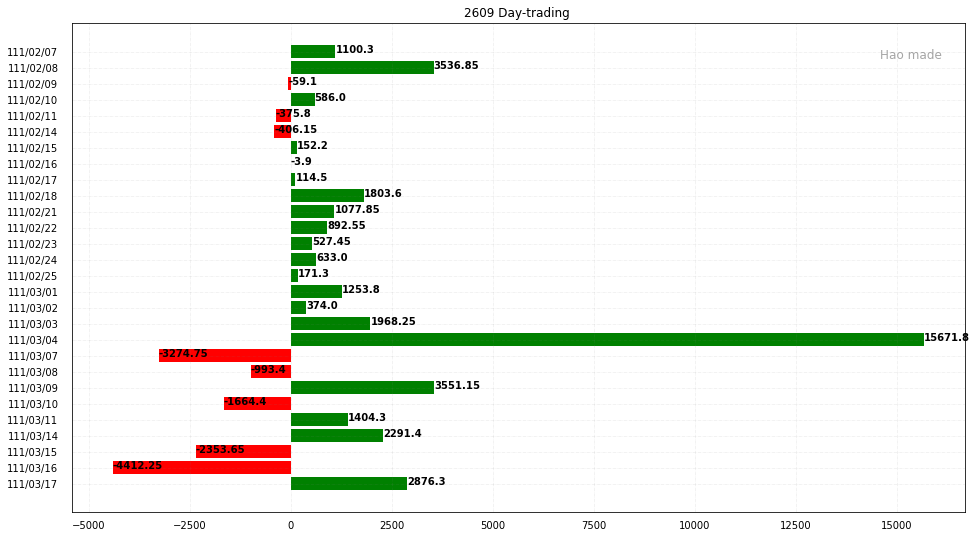

 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220201&stockNo=2607
 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220301&stockNo=2607
最後日期 111/03/17 已存檔


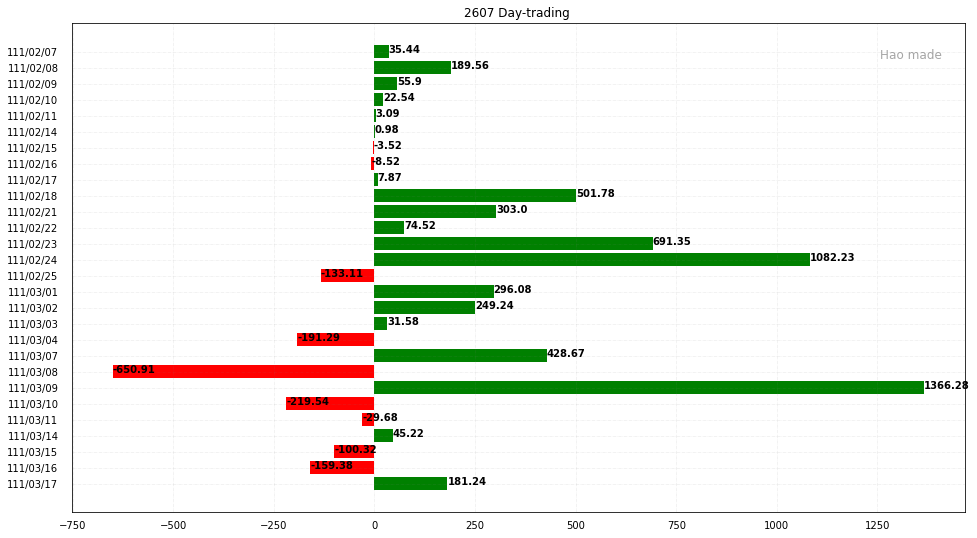

 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220201&stockNo=2615
 - processing: https://www.twse.com.tw/exchangeReport/TWTB4U2?response=csv&date=20220301&stockNo=2615
最後日期 111/03/17 已存檔


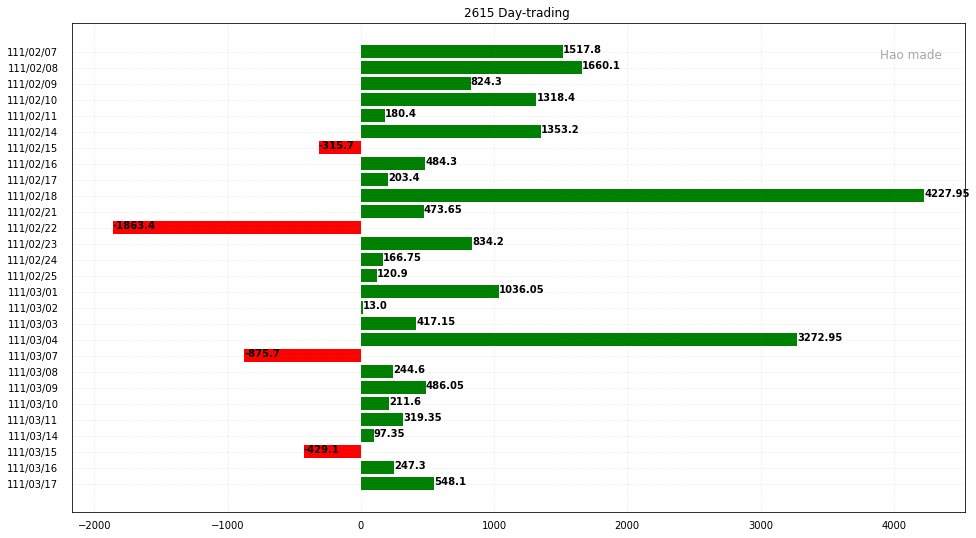

In [261]:
if __name__ == '__main__':  # 內容只會在main的文本檔執行
    save_file_path = 'day_trade'
#     stock_list = ['8046','2330','2607','2603','2606','2609']
#     stock_list = ['2603','2605','2606','2607','2609','2610','2611','2612','2613','2615','2617','2618','2637','2641']
    start_month = '2022-02'
    end_month = '2022-03'
    list_name = 'stock_list.txt'
    
    
    S=stock(save_file_path)  # 初始化，會去確認資料夾
    stock_list = S.get_run_list(list_name)
    
    for stock_id in stock_list:
        result = S.run_crawl_stock(save_file_path, stock_id, start_month, end_month)  # 爬取股票
    
        stock_id = result[1]
        S.draw_plt(S.check_df(save_file_path,stock_id), stock_id)
    
#     print(S.run_crawl_stock(save_file_path, stock_list, start_month, end_month))
#     print(S.check_df(save_file_path))
    